## **Import Libraries and modules**

In [ ]:
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

from keras.utils import np_utils

from tensorflow.keras.datasets import mnist

## Load MNIST data into train and test sets

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
print(X_train.shape)

(60000, 28, 28)


## Splitting the training data (50%) for autoencoders and classification

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_unsup, X_train_sup, y_train_unsup, y_train_sup = train_test_split(
    X_train, y_train, test_size=0.5, random_state=123)

In [ ]:
print (X_train_unsup.shape, X_train_sup.shape, y_train_unsup.shape, y_train_sup.shape)

(30000, 28, 28) (30000, 28, 28) (30000,) (30000,)


In [ ]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train_unsup.shape[1] * X_train_unsup.shape[2]

X_train_unsup = X_train_unsup.reshape((X_train_unsup.shape[0], num_pixels)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')
X_train_sup =  X_train_sup.reshape((X_train_sup.shape[0], num_pixels)).astype('float32')

## Pixel Normalization

In [ ]:
X_train_unsup  /= 255
X_train_sup  /= 255
X_test /= 255

In [ ]:
print (X_train_unsup.shape, X_train_sup.shape, y_train_unsup.shape, y_train_sup.shape)

(30000, 784) (30000, 784) (30000,) (30000,)


## Unsupervised Pretraining - Model

In [ ]:
input_dim = 784

input_layer = Input(shape=(input_dim, ))

encoder = Dense(500, activation='tanh')(input_layer)
coding = Dense(250, activation='tanh')(encoder)
decoder = Dense(500, activation='tanh')(coding)

ouput_layer = Dense(input_dim)(decoder)

autoencoder = Model(inputs=input_layer, outputs=ouput_layer)

autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_5 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_6 (Dense)              (None, 500)               125500    
_________________________________________________________________
dense_7 (Dense)              (None, 784)               392784    
Total params: 1,036,034
Trainable params: 1,036,034
Non-trainable params: 0
_________________________________________________________________


### Configuring Parameters

In [ ]:
epochs = 100
batch_size=128

### Model compiling and fitting

In [ ]:
from tensorflow.keras.optimizers import SGD

In [ ]:
autoencoder.compile(optimizer=SGD(lr=0.01, momentum=0.9),
                    loss='mean_squared_error')

In [ ]:
autoencoder.fit(x=X_train_unsup, y=X_train_unsup,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1)

Epoch 1/100
235/235 [==============================] - 1s 2ms/step - loss: 0.1008
Epoch 2/100
235/235 [==============================] - 1s 2ms/step - loss: 0.0686
Epoch 3/100
235/235 [==============================] - 1s 2ms/step - loss: 0.0622
Epoch 4/100
235/235 [==============================] - 1s 2ms/step - loss: 0.0577
Epoch 5/100
235/235 [==============================] - 1s 2ms/step - loss: 0.0541
Epoch 6/100
235/235 [==============================] - 1s 2ms/step - loss: 0.0508
Epoch 7/100
235/235 [==============================] - 1s 2ms/step - loss: 0.0480
Epoch 8/100
235/235 [==============================] - 1s 2ms/step - loss: 0.0456
Epoch 9/100
235/235 [==============================] - 1s 2ms/step - loss: 0.0435
Epoch 10/100
235/235 [==============================] - 1s 2ms/step - loss: 0.0416
Epoch 11/100
235/235 [==============================] - 1s 2ms/step - loss: 0.0400
Epoch 12/100
235/235 [==============================] - 1s 2ms/step - loss: 0.0385
Epoch 13/100


In [ ]:
reconstructed_image = autoencoder.predict(X_train_unsup[0].reshape(1, 784)).reshape(28,28)

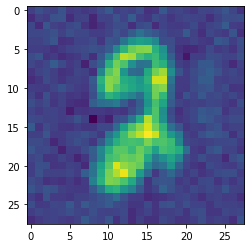

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(reconstructed_image)

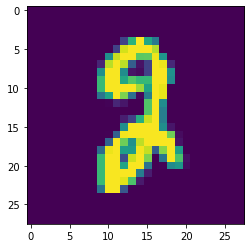

In [ ]:
original_image = X_train_unsup[0].reshape(28,28)

plt.imshow(original_image)

## Classification using Transfer Learning

In [ ]:
# mark all layers as non-trainable
for layer in autoencoder.layers:
  layer.trainable = False

In [ ]:
model = Dense(100, activation='relu')(autoencoder.layers[-3].output)
predictions = Dense(10, activation='softmax')(model)

model = Model(inputs=autoencoder.inputs, outputs=predictions)

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_5 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_12 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
Total params: 543,860
Trainable params: 26,110
Non-trainable params: 517,750
_________________________________________________________________


### One-hot encoding

In [ ]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train_sup = np_utils.to_categorical(y_train_sup, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [ ]:
Y_train_sup[:10]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
Y_test[:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

### Model compiling and fitting

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])

In [ ]:
# fit model
model.fit(X_train_sup, Y_train_sup, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 0.4574 - accuracy: 0.8711 - val_loss: 0.2601 - val_accuracy: 0.9272
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2348 - accuracy: 0.9319 - val_loss: 0.2035 - val_accuracy: 0.9410
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1815 - accuracy: 0.9470 - val_loss: 0.1704 - val_accuracy: 0.9506
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1495 - accuracy: 0.9568 - val_loss: 0.1472 - val_accuracy: 0.9565
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1262 - accuracy: 0.9645 - val_loss: 0.1355 - val_accuracy: 0.9591
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1096 - accuracy: 0.9685 - val_loss: 0.1255 - val_accuracy: 0.9637
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0964 - accuracy: 0.9725 - val_loss: 0.1178 - val_accuracy: 0.9657
Epoch 